<a href="https://colab.research.google.com/github/ebhawana/email_spam_detection/blob/main/Email_spam_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This classifier model aims to learn patterns from historical labeled emails (spam vs ham), using features such as Words/phrases used and email structure.

IT then generalizes this learning to classify new, unseen emails correctly.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk  #we perform data preprocessing tasks like removing unnecessary words, and punctuation and converting text to lowercase using NLTK
nltk.download('stopwords')#Downloads a list of common words (like "the", "a", "is") that are often removed from text during preprocessing
nltk.download('punkt')#ownloads data for tokenizing sentences into words.
nltk.download('punkt_tab')
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
import re# Provides regular expression operations for pattern matching in text.
from collections import Counter
from sklearn.preprocessing import LabelEncoder

# Model Building
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score


import os
# Get the current working directory
current_dir = os.getcwd()

# Add the current directory to NLTK's data path
if current_dir not in nltk.data.path:
    nltk.data.path.append(current_dir)
    print("Added current directory to NLTK data path:", current_dir)
else:
    print("Current directory is already in NLTK data path:", current_dir)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Added current directory to NLTK data path: /content


In [ ]:
# Importing the Dataset Initial exploration and data cleaning
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Projects/Email.csv",encoding='latin1')
print(data.sample(5))
print(data.shape,'\n')
print(data.info())

        v1                                                 v2 Unnamed: 2  \
1141  spam  I don't know u and u don't know me. Send CHAT ...        NaN   
327    ham  I'd say that's a good sign but, well, you know...        NaN   
156    ham                        I'm leaving my house now...        NaN   
479    ham  When're you guys getting back? G said you were...        NaN   
2828  spam  Send a logo 2 ur lover - 2 names joined by a h...        NaN   

     Unnamed: 3 Unnamed: 4  
1141        NaN        NaN  
327         NaN        NaN  
156         NaN        NaN  
479         NaN        NaN  
2828        NaN        NaN  
(5572, 5) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unname

In [ ]:
df=data.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1)

In [ ]:
df.rename(columns={'v1':'result','v2':'emails'}, inplace=True)

In [ ]:
df.isnull().sum()

,0
result,0
emails,0


In [ ]:
df.duplicated().sum()

np.int64(403)

In [ ]:
df.drop_duplicates(keep='first',inplace=True)

In [ ]:
df.shape

(5169, 2)

In [ ]:
df.head(5)

,result,emails
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
#EDA:
df['result'].value_counts()

,count
result,
ham,4516
spam,653


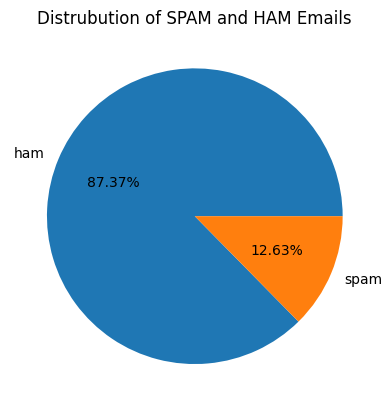

In [ ]:
#plotting the pie chart
x=df['result'].value_counts()
plt.pie(x.values,labels=x.index,autopct='%1.2f%%')
plt.title('Distrubution of SPAM and HAM Emails')
plt.show()

From above graph we can see that most of the emails(87.37%) are not spam and 12.63% of emails very small portion of emails are classified as spam.

In [ ]:
data = df.copy()
data['Length'] = data['emails'].apply(len)
data['num_words'] = data['emails'].apply(word_tokenize).apply(len)
data['num_sentence'] = data['emails'].apply(sent_tokenize).apply(len)
data.head(2)

,result,emails,Length,num_words,num_sentence
0,ham,"Go until jurong point, crazy.. Available only ...",111,24,2
1,ham,Ok lar... Joking wif u oni...,29,8,2


In [ ]:
#Average length of spam and ham emails
avg_length_spam = data[data['result'] == 'spam']['Length'].mean()
avg_length_ham = data[data['result'] == 'ham']['Length'].mean()
print("Average length of spam emails:", avg_length_spam)
print("Average length of ham emails:", avg_length_ham)

Average length of spam emails: 137.89127105666157
Average length of ham emails: 70.45925597874225


In [ ]:

#Average words of spam and ham emails
average_words_spam=data[data['result']=='spam']['num_words'].mean()
average_words_ham=data[data['result']=='ham']['num_words'].mean()
print("Average words in spam emails:",average_words_spam)
print("Average words in ham emails:",average_words_ham)



Average words in spam emails: 27.6676875957121
Average words in ham emails: 17.12378210806023


In [ ]:
#Average Sentence for Spam and Ham
average_sentence_spam=data[data['result']=='spam']['num_sentence'].mean()
average_sentence_ham=data[data['result']=='ham']['num_sentence'].mean()

print("Average sentence in spam emails:",average_sentence_spam)
print("Average sentence in ham emails:",average_sentence_ham)


Average sentence in spam emails: 2.970903522205207
Average sentence in ham emails: 1.8201948627103632


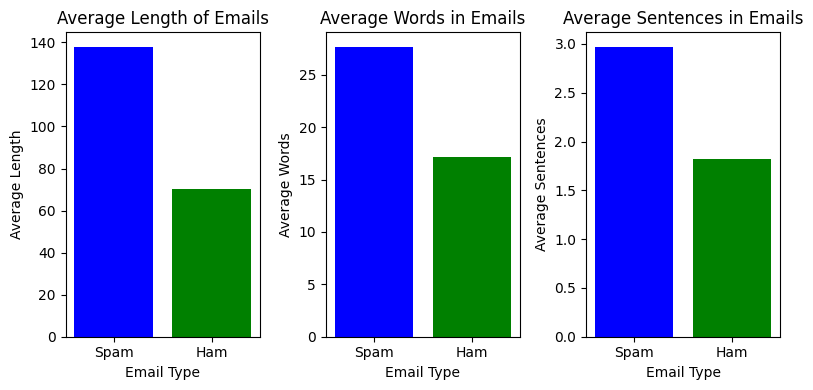

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(8, 4))  # 1 row, 3 columns

# Plot 1: Average Length
axes[0].bar(['Spam', 'Ham'], [avg_length_spam, avg_length_ham], color=['Blue', 'green'])
axes[0].set_title('Average Length of Emails')
axes[0].set_xlabel('Email Type')
axes[0].set_ylabel('Average Length')

# Plot 2: Average Words
axes[1].bar(['Spam', 'Ham'], [average_words_spam, average_words_ham], color=['blue', 'green'])
axes[1].set_title('Average Words in Emails')
axes[1].set_xlabel('Email Type')
axes[1].set_ylabel('Average Words')

# Plot 3: Average Sentences
axes[2].bar(['Spam', 'Ham'], [average_sentence_spam, average_sentence_ham], color=['blue', 'green'])
axes[2].set_title('Average Sentences in Emails')
axes[2].set_xlabel('Email Type')
axes[2].set_ylabel('Average Sentences')


plt.tight_layout()  # Adjust spacing between subplots
plt.show()


In [ ]:
#Relationship between Length and Spam
correlation = data['Length'].corr((data['result'] == 'spam').astype(int))
print("Correlation coefficient between email length and spam classification:", correlation)


Correlation coefficient between email length and spam classification: 0.38471706671430717


As we found that there is a positive correlation (correlation coefficient: 0.38) between email length and spam classification. This means that, on average, spam emails tend to be slightly longer than non-spam emails. However, it’s important to note that the correlation is not very strong, indicating that other factors may also influence whether an email is classified as spam


The Relationship between Features are 
                 Length  num_words  num_sentence
Length        1.000000   0.965760      0.624139
num_words     0.965760   1.000000      0.679971
num_sentence  0.624139   0.679971      1.000000


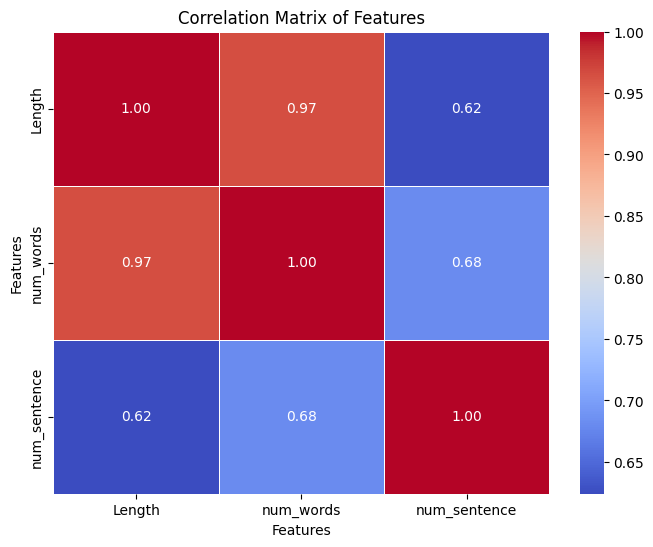

In [ ]:
#relstionship between features
correlation_matrix = data[['Length', 'num_words', 'num_sentence']].corr()
print("The Relationship between Features are \n",correlation_matrix )

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Features')
plt.xlabel('Features')
plt.ylabel('Features')
plt.show()

The correlation matrix indicates strong positive correlations between email length and the number of words (0.97) as well as between the number of words and the number of sentences (0.68). This suggests that longer emails tend to have more words, and emails with more words tend to have more sentences. However, the correlation between email length and the number of sentences is weaker (0.62). This implies that while longer emails may have more sentences, the relationship is not as strong as with the number of words.


**DATA PREPROCESSING**



In [ ]:
data['transform_text'] = data['emails'].str.lower()#converting to lower case

# Tokenization
data['transform_text'] = data['transform_text'].apply(word_tokenize)

# Removing special characters
data['transform_text'] = data['transform_text'].apply(lambda x: [re.sub(r'[^a-zA-Z0-9\s]', '', word) for word in x])

# Removing stop words and punctuation
stop_words = set(stopwords.words('english'))
data['transform_text'] = data['transform_text'].apply(lambda x: [word for word in x if word not in stop_words and word not in string.punctuation])

# Stemming
ps = PorterStemmer()
data['transform_text'] = data['transform_text'].apply(lambda x: [ps.stem(word) for word in x])

# Convert the preprocessed text back to string
data['transform_text'] = data['transform_text'].apply(lambda x: ' '.join(x))

# Display the preprocessed data
print(data[['emails', 'transform_text']].head())

                                              emails  \
0  Go until jurong point, crazy.. Available only ...   
1                      Ok lar... Joking wif u oni...   
2  Free entry in 2 a wkly comp to win FA Cup fina...   
3  U dun say so early hor... U c already then say...   
4  Nah I don't think he goes to usf, he lives aro...   

                                      transform_text  
0  go jurong point crazi avail bugi n great world...  
1                              ok lar joke wif u oni  
2  free entri 2 wkli comp win fa cup final tkt 21...  
3                u dun say earli hor u c alreadi say  
4            nah nt think goe usf live around though  


In [ ]:
spam_emails = data[data['result'] == 'spam']['transform_text']
spam_emails


,transform_text
2,free entri 2 wkli comp win fa cup final tkt 21...
5,freemsg hey darl 3 week word back like fun sti...
8,winner valu network custom select receivea 900...
9,mobil 11 month u r entitl updat latest colour ...
11,six chanc win cash 100 20000 pound txt csh11 s...
...,...
5537,want explicit sex 30 sec ring 02073162414 cost...
5540,ask 3mobil 0870 chatlin inclu free min india c...
5547,contract mobil 11 mnth latest motorola nokia e...
5566,remind o2 get 250 pound free call credit detai...


In [ ]:
spam_words = ' '.join(spam_emails)
spam_words

'free entri 2 wkli comp win fa cup final tkt 21st may 2005 text fa 87121 receiv entri question std txt rate c appli 08452810075over18 freemsg hey darl 3 week word back like fun still tb ok xxx std chg send 150 rcv winner valu network custom select receivea 900 prize reward claim call 09061701461 claim code kl341 valid 12 hour mobil 11 month u r entitl updat latest colour mobil camera free call mobil updat co free 08002986030 six chanc win cash 100 20000 pound txt csh11 send 87575 cost 150pday 6day 16 tsandc appli repli hl 4 info urgent 1 week free membership 100000 prize jackpot txt word claim 81010 c wwwdbuknet lccltd pobox 4403ldnw1a7rw18 xxxmobilemovieclub use credit click wap link next txt messag click http wap xxxmobilemovieclubcom nqjkgighjjgcbl england v macedonia dont miss goalsteam news txt ur nation team 87077 eg england 87077 tri wale scotland 4txt120 poboxox36504w45wq 16 thank subscript rington uk mobil charg 5month pleas confirm repli ye repli charg 07732584351 rodger burn

Top 10 Most Common Words in Spam Emails:
call: 321 occurrences
free: 191 occurrences
2: 157 occurrences
txt: 141 occurrences
u: 135 occurrences
text: 122 occurrences
ur: 119 occurrences
mobil: 114 occurrences
stop: 106 occurrences
repli: 103 occurrences


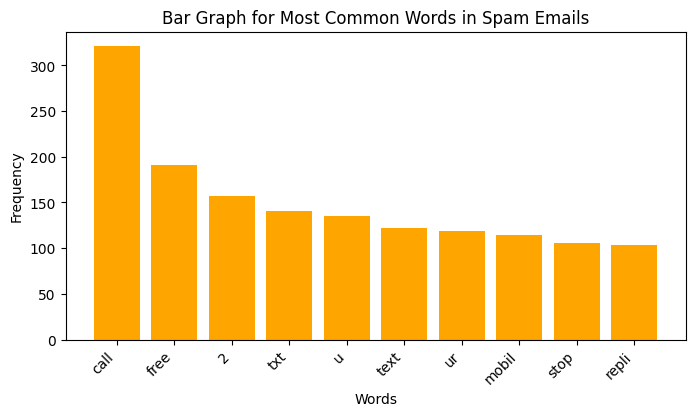

In [ ]:
spam_emails = data[data['result'] == 'spam']['transform_text']
# Tokenize the text in spam emails
spam_words = ' '.join(spam_emails).split()

# Count occurrences of each word
word_counts = Counter(spam_words)

# Find the most common words
most_common_words_spam = word_counts.most_common(10)
print("Top 10 Most Common Words in Spam Emails:")
for word, count in most_common_words_spam:
    print(f"{word}: {count} occurrences")


# Plot Bar Graph
plt.figure(figsize=(8, 4))
words, counts = zip(*most_common_words_spam)#he words and their corresponding frequencies are extracted from most_common_words using zip
plt.bar(words, counts, color='orange')
plt.title('Bar Graph for Most Common Words in Spam Emails')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()

Top 10 Most Common Words in ham Emails:
u: 904 occurrences
go: 404 occurrences
nt: 352 occurrences
get: 352 occurrences
2: 290 occurrences
gt: 288 occurrences
lt: 287 occurrences
come: 275 occurrences
ok: 251 occurrences
got: 238 occurrences


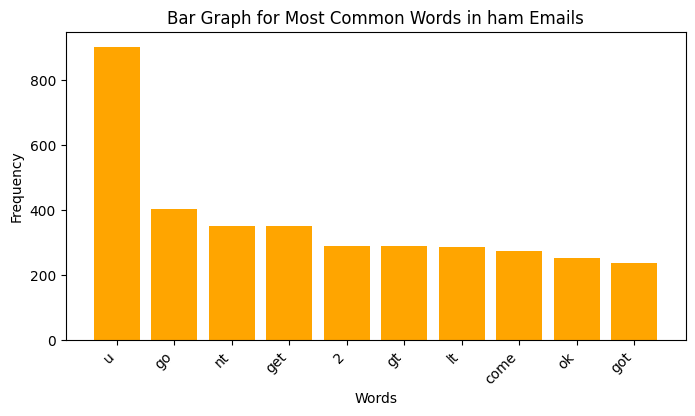

In [ ]:
ham_emails = data[data['result'] == 'ham']['transform_text']
# Tokenize the text in spam emails
ham_words = ' '.join(ham_emails).split()
# Count occurrences of each word
word_counts = Counter(ham_words)
# Find the most common words
most_common_words = word_counts.most_common(10)
#print(most_common_words)
print("Top 10 Most Common Words in ham Emails:")
for word, count in most_common_words:
    print(f"{word}: {count} occurrences")

# Plot Bar Graph
plt.figure(figsize=(8, 4))
words, counts = zip(*most_common_words)
plt.bar(words, counts, color='orange')
plt.title('Bar Graph for Most Common Words in ham Emails')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')

plt.show()

In [ ]:
#PRepraring data for modeling
encoder = LabelEncoder()
data['result'] = encoder.fit_transform(data['result'])
data.sample(2)

#data spliting and vectorization
tfidf = TfidfVectorizer(max_features=3000)
X = tfidf.fit_transform(data['emails']).toarray()
y = data['result']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# support vector model
svc_classifier = SVC()
svc_classifier.fit(X_train, y_train)
y_pred_svc = svc_classifier.predict(X_test)
accuracy_svc = accuracy_score(y_test, y_pred_svc)
print(f"SVM Accuracy: {accuracy_svc:.2f}")
print("confusion Matrix :",confusion_matrix(y_test,y_pred_svc))
print("Precision Score: ",precision_score(y_test,y_pred_svc))

SVM Accuracy: 0.99
confusion Matrix : [[889   0]
 [ 14 131]]
Precision Score:  1.0


In [ ]:
#Random forest Model
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)
y_pred_rf = rf_classifier.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf:.2f}")
print("confusion Matrix :",confusion_matrix(y_test,y_pred_rf))
print("Precision Score: ",precision_score(y_test,y_pred_rf))

Random Forest Accuracy: 0.98
confusion Matrix : [[888   1]
 [ 18 127]]
Precision Score:  0.9921875


In [ ]:
#Naive Bayes Model
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)
y_pred_nb = nb_classifier.predict(X_test)
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print(f"Naive Bayes Accuracy: {accuracy_nb:.2f}")
print("confusion Matrix :",confusion_matrix(y_test,y_pred_nb))
print("Precision Score: ",precision_score(y_test,y_pred_nb))

Naive Bayes Accuracy: 0.98
confusion Matrix : [[889   0]
 [ 24 121]]
Precision Score:  1.0


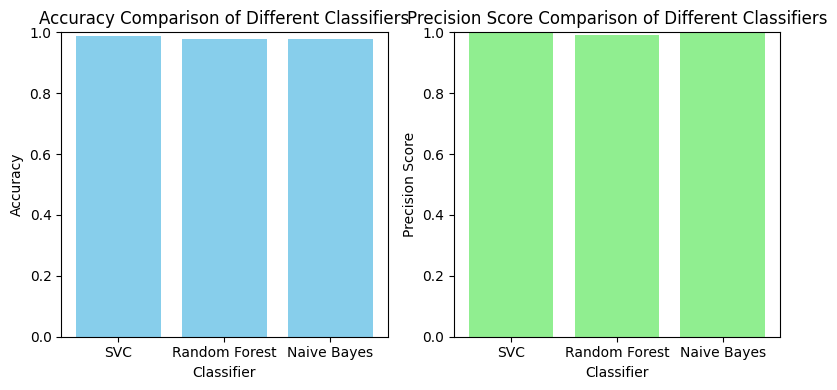

In [ ]:
# Calculate precision scores for each classifier
precision_svc = precision_score(y_test, y_pred_svc)
precision_rf = precision_score(y_test, y_pred_rf)
precision_nb = precision_score(y_test, y_pred_nb)

# Create lists to store accuracies and precision scores
classifiers = ['SVC', 'Random Forest', 'Naive Bayes']
accuracies = [accuracy_svc, accuracy_rf, accuracy_nb]
precision_scores = [precision_svc, precision_rf, precision_nb]

# Plot bar graph for accuracies and precision scores side by side
fig, axes = plt.subplots(1, 2, figsize=(8,4))

# Plot bar graph for accuracies
axes[0].bar(classifiers, accuracies, color='skyblue')
axes[0].set_xlabel('Classifier')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Accuracy Comparison of Different Classifiers')
axes[0].set_ylim(0, 1)

# Plot bar graph for precision scores
axes[1].bar(classifiers, precision_scores, color='lightgreen')
axes[1].set_xlabel('Classifier')
axes[1].set_ylabel('Precision Score')
axes[1].set_title('Precision Score Comparison of Different Classifiers')
axes[1].set_ylim(0, 1)
plt.tight_layout()
plt.show()

In [ ]:
new_emails = [
    "Get a free iPhone now!",
    "Hey, how's it going?",
    "Congratulations! You've won a prize!",
    "Reminder: Meeting at 2 PM tomorrow."
]

# Convert new data into numerical vectors using the trained tfidf_vectorizer
new_X = tfidf.transform(new_emails)
new_X_dense = new_X.toarray()

# Use the trained SVM model to make predictions
svm_predictions = svc_classifier.predict(new_X_dense)

# Print the predictions
for email, prediction in zip(new_emails, svm_predictions):
    if prediction == 1:
        print(f"'{email}' is predicted as spam.")
    else:
        print(f"'{email}' is predicted as ham.")

'Get a free iPhone now!' is predicted as spam.
'Hey, how's it going?' is predicted as ham.
'Congratulations! You've won a prize!' is predicted as spam.
'Reminder: Meeting at 2 PM tomorrow.' is predicted as ham.


In [ ]:
def predict_email(email):
    # Convert email into numerical vector using the trained TF-IDF vectorizer
    email_vector = tfidf.transform([email])

    # Convert sparse matrix to dense array
    email_vector_dense = email_vector.toarray()

    # Use the trained SVM model to make predictions
    prediction = svc_classifier.predict(email_vector_dense)

    # Print the prediction
    if prediction[0] == 1:
        print("The email is predicted as spam.")
    else:
        print("The email is predicted as ham.")

# Get user input for email
user_email = input("Enter the email text: ")

# Predict whether the input email is spam or ham
predict_email(user_email)

Enter the email text: Dont miss the opportunity
The email is predicted as ham.
